# Raport - Symulator Tomografu Komputerowego
### Skład grupy:
- Igor Taciak 155997
- Mateusz Górecki 155836

### Zastosowany model tomografu:
- Równoległy

### Zastosowany język programowania oraz dodatkowe biblioteki:
```python
Język - Python 3.12

Biblioteki:
- math (wbudowana)
- numpy
- matplotlib
- skimage
- streamlit
```

### Opis głównych funkcji programu (plik źródłowy obliczenia.py)
#### Pozyskanie odczytów dla poszczególnych detektorów
By uzyskać odczyt dla danego detektora trzeba:
1. Uzyskać jego pozycję oraz pozycję emitera, z którego wysyłana jest wiązka promieni.
2. Uzyskać współrzędne punktów przez które przechodzi wiązka promieni.
3. Obliczyć sinogram (każda kolumna odpowiada jednemu detektorowi)

#### Funkcja obliczająca pozycje emiterów oraz detektorów dla równoległego modelu tomografu według poniższych wzorów:
![Wzory na pozycje emiterów oraz detektorów](./res/emitery_detektory_wzory.png)
```python
def get_parallel_rays(radius, pos, angle, span, num_rays):
    """
    Funkcja obliczająca współrzędne emitorów i detektorów dla zadanych parametrów

    :param radius: promień okręgu
    :param pos: środek badanego zdjęcia
    :param angle: kąt pod którym padają promienie (w równaniach oznaczany alfa)
    :param span: rozpiętość promieni (w równania oznaczana phi)
    :param num_rays: liczba emiterów oraz detektorów

    :return: ndarray współrzędnych emiterów i odpowiadających im detektorów
    """

    alpha = np.radians(angle)
    theta = np.radians(span)

    # Wektor indeksów promieni
    ray_indices = np.linspace(0, num_rays - 1, num_rays)

    # Obliczenie kątów dla detektorów i emiterów
    detector_angles = alpha - (ray_indices * theta / (num_rays - 1)) + theta / 2
    emitter_angles = alpha + np.pi - (theta / 2) + (ray_indices * theta / (num_rays - 1))

    # Obliczenie współrzędnych emiterów
    x_e = radius * np.cos(emitter_angles) + pos[0]
    y_e = radius * np.sin(emitter_angles) + pos[1]

    # Obliczenie współrzędnych detektorów
    x_d = radius * np.cos(detector_angles) + pos[0]
    y_d = radius * np.sin(detector_angles) + pos[1]

    # Łączenie współrzędnych w jedną tablicę: dla każdego promienia
    # element = [[x_det, x_em], [y_det, y_em]]
    rays = np.empty((num_rays, 2, 2))
    rays[:, 0, 0] = x_e
    rays[:, 0, 1] = x_d
    rays[:, 1, 0] = y_e
    rays[:, 1, 1] = y_d

    return rays
```

#### Funkcja obliczająca współrzędne punktów przez które przechodzi wiązka promieni (algorytm Bresenhama)
Poniższy algorytm to algorytm Bresenhama z osią wiodąca Y, w którym tylko jeden piksel na każdy wiersz jest rozświetlany. Zaimplementowany na podstawie poniższej listy kroków:
```

The points (x1, y1) and (x2, y2) are assumed not equal
ε is assumed to be real.

Let Δx = x2 − x1
Let Δy = y2 − y1
Let m = |Δx / Δy|

Let i  = floor(x1)
Let j1 = floor(y1)
Let j2 = floor(y2)

if Δx > 0:
    iinc = 1
    ε = −(1 − (x1 − i) − (y1 − j1) * (Δx / Δy))
else:
    iinc = −1
    ε = −((x1 − i) − (y1 − j1) * (Δx / Δy))
end if

for j from j1 to j2:
    while ε ≥ 0:
        i = i + iinc
        ε = ε − 1.0
    end while

    illuminate(i, j)

    ε = ε + m
next j

finish
```
```python
def get_bresenham_points(x1, x2, y1, y2):
    """
    Funkcja obliczająca współrzędne promieni na podstawie algorytmu Bresenhama

    :param x1: - współrzędne x emitera
    :param x2: - współrzędne x detektora
    :param y1: - współrzędne y emitera
    :param y2: - współrzędne y detektora

    :return: lista punktów odpowiadających wiązce
    """

    points = []

    dx = x2 - x1
    dy = y2 - y1

    # Współczynnik nachylenia (odwrotnego bo dx/dy a nie dy/dx)
    m = abs(dx / dy)

    # Zaokrąglenie współrzędnych do najbliższej dolnej krawędzi piksela
    i = int(x1)
    j1 = int(y1)
    j2 = int(y2)

    # Ustalenie kierunku ruchu w poziomie
    if dx > 0:
        i_inc = 1
        error = -(1 - (x1 - i) - (y1 - j1) * (dx/dy))
    else:
        i_inc = -1
        error = -((x1 - i) - (y1 - j1) * (dx/dy))

    for j in range(j1, j2+1):
        # Jeśli skumulowany błąd przekroczył próg przechodzimy w bok (x)
        while error >= 0:
            i += i_inc
            error -= 1
        points.append([i, j])
        error += m
    return points
```
#### Funkcja obliczająca sinogram
Poniższa funkcja generuje sinogram obrazu. Dla różnych kątów i pozycji emiterów oraz detektorów wyznaczane są wiązki przechodzące przez obraz, a następnie sumowane są wartości pikseli przecinanych przez każdą z nich. Uzyskane sumy tworzą sinogram — reprezentację danych, które odwzorowują, ile „jasności” promienie napotkały na swojej drodze przez obiekt.
```python
def calculate_sinogram(img, steps, span, num_rays, max_angle, intermediate=False):
    """
    Funkcja obliczająca sinogram obrazu wejściowego

    :param img: - ndarray obrazu wejściowego
    :param steps: - ilość kroków (emiterów oraz detektorów)
    :param span: - zakres promieni
    :param num_rays: - liczba promieni
    :param max_angle: - maksymalny kąt
    :param intermediate: możliwość uzyskania wyników pośrednich jeżeli True

    :return ndarray odpowiadający sinogramowi
    """
    # Pusty ndarray wypełniany dalej sinogramem (czarny obraz)
    sinogram = np.zeros((steps, num_rays))
    if intermediate:
        iterations = []

    for idx in range(steps):
        # Kąt padania promieni i współrzędne emiterów oraz detektorów
        angle = idx * (max_angle/steps)
        rays = get_parallel_rays(max(img.shape[0]//2, img.shape[1]//2) * np.sqrt(2),
                                 (img.shape[0]//2, img.shape[1]//2), angle, span, num_rays)
        for ray_idx, ray in enumerate(rays):
            # Współrzędne wiązek z emiterów
            emitter_value = 0
            points = get_bresenham_points(ray[0][0], ray[0][1], ray[1][0], ray[1][1])
            for point in points:
                # Rozświetlanie pikseli w granicach obrazu
                if (0 <= point[0] < img.shape[0]) and (0 <= point[1] < img.shape[1]):
                    emitter_value += img[point[0]][point[1]]
            sinogram[idx][ray_idx] = emitter_value
        if intermediate:
            iterations.append(copy.deepcopy(sinogram))

    # By wyświetlić prawidłowo trezeba transponować ponieważ format odpowiada formatowi
    # danych zbieranych przez rzeczywisty tomograf (każdy wiersz to wyniki uzyskane
    # dla danego kąta), który powodowałby błędne wykreślenie sinogramu
    if intermediate:
        return iterations
    else:
        return sinogram
```
### Filtrowanie sinogramu
Poniższa funkcja służy do filtrowania sinogramu za pomocą splotu sinogramu oraz danego jądra. Do filtrowania sinogramów używane było jądro o wymiarach 9x9.
```python
def filter_sinogram(sinogram, kernel):
    """
    Dokonuje dwuwymiarowego splotu sinogramu z podanym 2D kernelem.

    :param sinogram: macierz sinogramu (2D ndarray)
    :param kernel: dwuwymiarowy jądro filtra (2D ndarray)
    :return: ndarray przefiltrowanego sinogramu o tych samych wymiarach co wejściowy
    """
    # Wykonywany jest splot 2D z trybem 'same', który zapewnia, że wynik ma te same wymiary co macierz wejściowa.
    filtered = convolve2d(sinogram, kernel, mode='same', boundary='fill', fillvalue=0)
    return filtered
```

### Zrekonstruowany obraz
Do zrekonstruowania obrazu z sinogramu została użyta Odwrotna Transformata Radona, która została zaimplementowana poniżej. Dodatkowo wynik na końcu jest normalizowany (funkcja normalize).
```python
def reverse_radon_transform(img, sinogram, steps, span, num_rays, max_angle, intermediate=False):
    """
    Funkcja uzyskująca rekonstrukcję oryginalnego obrazu na podstawie sinogramu używając
    odwróconej transformaty Radona

    :param img: - ndarray obrazu wejściowego
    :param sinogram: - sinogram wejściowy
    :param steps: - ilość kroków (emiterów oraz detektorów)
    :param span: - zakres promieni
    :param num_rays: - liczba promieni
    :param max_angle: - maksymalny kąt
    :param intermediate: możliwość uzyskania wyników pośrednich jeżeli True

    :return: ndarray przedstawiąjący zrekonstruowany obraz wejściowy
    """
    out_image = np.zeros((img.shape[0], img.shape[1]))
    if intermediate:
        iterations = []

    for idx in range(steps):
        angle = idx * max_angle / steps
        rays = get_parallel_rays(max(img.shape[0] // 2, img.shape[1] // 2) * np.sqrt(2),
                                 (img.shape[0] // 2, img.shape[1] // 2), angle, span, num_rays)
        for ray_idx, ray in enumerate(rays):
            points = get_bresenham_points(ray[0][0], ray[0][1], ray[1][0], ray[1][1])
            for point in points:
                # Tylko dla punktów zawierających się w sinogramie
                if (0 <= point[0] < img.shape[0]) and (0 <= point[1] < img.shape[1]):
                    out_image[point[0]][point[1]] += sinogram[idx][ray_idx]
                    if intermediate:
                        iterations.append(copy.deepcopy(out_image))

    if intermediate:
        return iterations
    else:
        return normalize(out_image)

        
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())
```
### Wyznaczanie RMSE
RMSE wyznaczane jest na podstawie wzoru:
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$
za pomocą poniższej funkcji:
```python
def rmse(img1, img2):
    return np.sqrt(np.mean(np.square(img1 - img2)))
```

### Działanie dla dwóch przykładowych obrazków

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
import numpy as np
from obliczenia import reverse_radon_transform, calculate_sinogram, filter_sinogram, create_shepp_logan_kernel, rmse
import os

In [2]:
image1 = io.imread("./scans/SADDLE_PE.jpg")
image1 = rgb2gray(image1)
image2 = io.imread("./scans/Shepp_logan.jpg")
image2 = rgb2gray(image2)
file_name1 = os.path.splitext(os.path.basename("./scans/SADDLE_PE.jpg"))[0]
file_name2 = os.path.splitext(os.path.basename("./scans/Shepp_logan.jpg"))[0]

In [3]:
# Obliczenie obu sinogramów
sinogram1 = calculate_sinogram(image1, steps=180, span=120, num_rays=250, max_angle=180)
sinogram2 = calculate_sinogram(image2, steps=180, span=120, num_rays=250, max_angle=180)

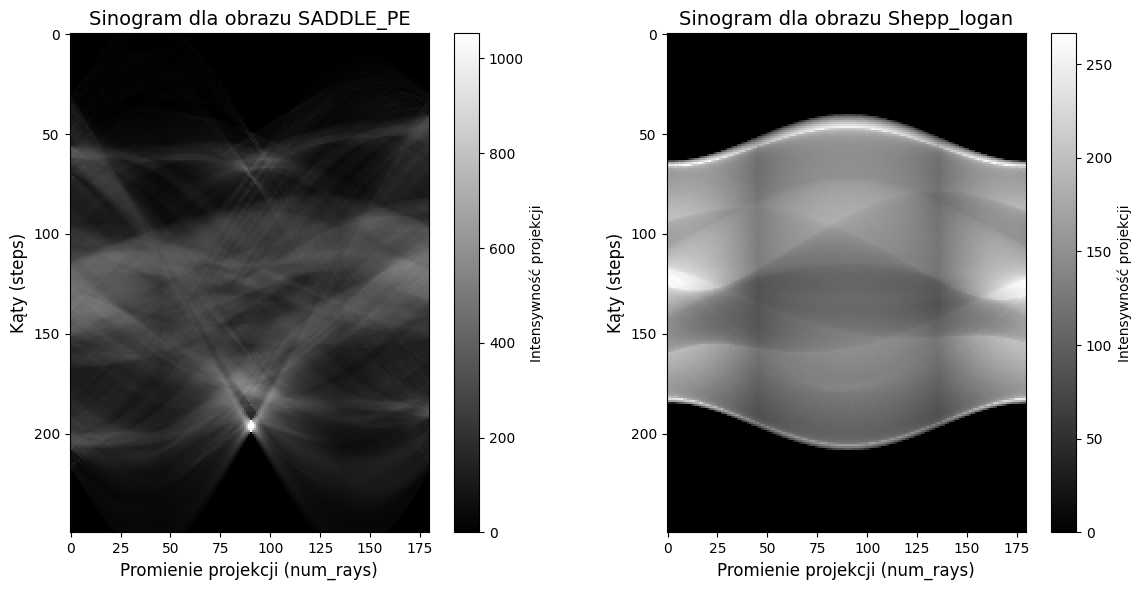

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Wykres dla image1
cax1 = axes[0].imshow(np.transpose(sinogram1), cmap="gray", aspect='equal')
axes[0].set_title(f'Sinogram dla obrazu {file_name1}', fontsize=14)
axes[0].set_xlabel('Promienie projekcji (num_rays)', fontsize=12)
axes[0].set_ylabel('Kąty (steps)', fontsize=12)
fig.colorbar(cax1, ax=axes[0], label='Intensywność projekcji')

# Wykres dla image2
cax2 = axes[1].imshow(np.transpose(sinogram2), cmap="gray", aspect='equal')
axes[1].set_title(f'Sinogram dla obrazu {file_name2}', fontsize=14)
axes[1].set_xlabel('Promienie projekcji (num_rays)', fontsize=12)
axes[1].set_ylabel('Kąty (steps)', fontsize=12)
fig.colorbar(cax2, ax=axes[1], label='Intensywność projekcji')

# Pokaż oba wykresy
plt.tight_layout()  # Dopasowanie wykresów, aby się nie nakładały
plt.show()


In [5]:
reconstructed1 = reverse_radon_transform(image1, sinogram1, steps=180, span=120, num_rays=250, max_angle=180)
reconstructed2 = reverse_radon_transform(image2, sinogram2, steps=180, span=120, num_rays=250, max_angle=180)

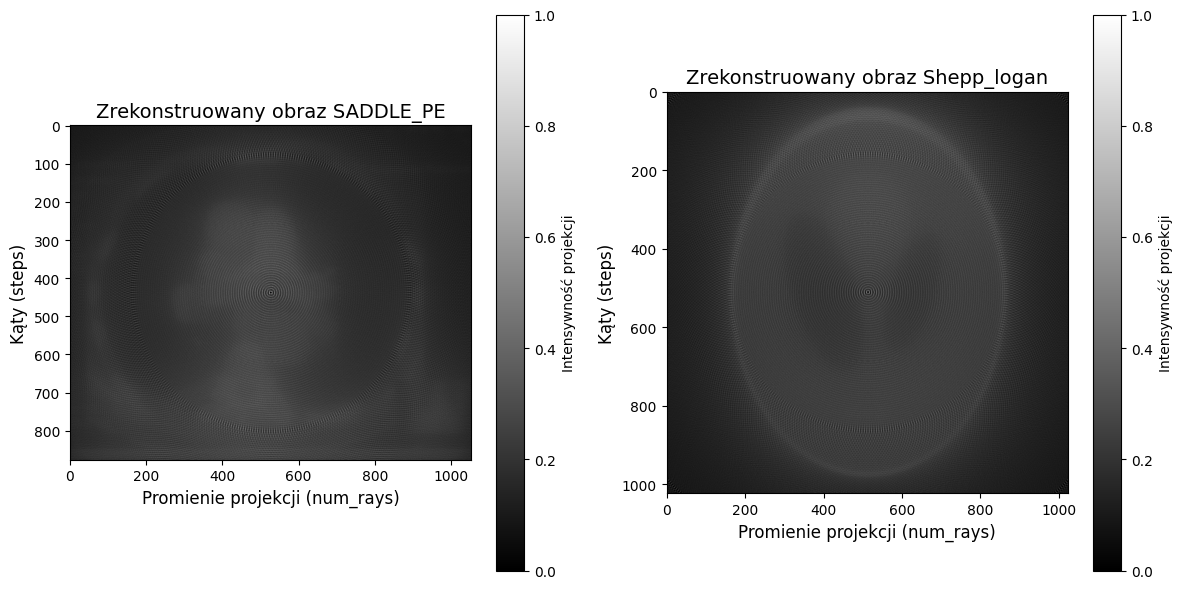

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Wykres dla zrekonstruowanego obrazu 1
cax1 = axes[0].imshow(reconstructed1, cmap="gray", aspect='equal')
axes[0].set_title(f'Zrekonstruowany obraz {file_name1}', fontsize=14)
axes[0].set_xlabel('Promienie projekcji (num_rays)', fontsize=12)
axes[0].set_ylabel('Kąty (steps)', fontsize=12)
fig.colorbar(cax1, ax=axes[0], label='Intensywność projekcji')

# Wykres dla zrekonstruowanego obrazu 2
cax2 = axes[1].imshow(reconstructed2, cmap="gray", aspect='equal')
axes[1].set_title(f'Zrekonstruowany obraz {file_name2}', fontsize=14)
axes[1].set_xlabel('Promienie projekcji (num_rays)', fontsize=12)
axes[1].set_ylabel('Kąty (steps)', fontsize=12)
fig.colorbar(cax2, ax=axes[1], label='Intensywność projekcji')

# Pokaż oba wykresy
plt.tight_layout()  # Dopasowanie wykresów, aby się nie nakładały
plt.show()

In [7]:
kernel = create_shepp_logan_kernel(size=9)
filtered_sinogram1 = filter_sinogram(sinogram1, kernel=kernel)
filtered_sinogram2 = filter_sinogram(sinogram2, kernel=kernel)
filtered_reconstructed1 = reverse_radon_transform(image1, filtered_sinogram1, steps=180, span=120, num_rays=250, max_angle=180)
filtered_reconstructed2 = reverse_radon_transform(image2, filtered_sinogram2, steps=180, span=120, num_rays=250, max_angle=180)

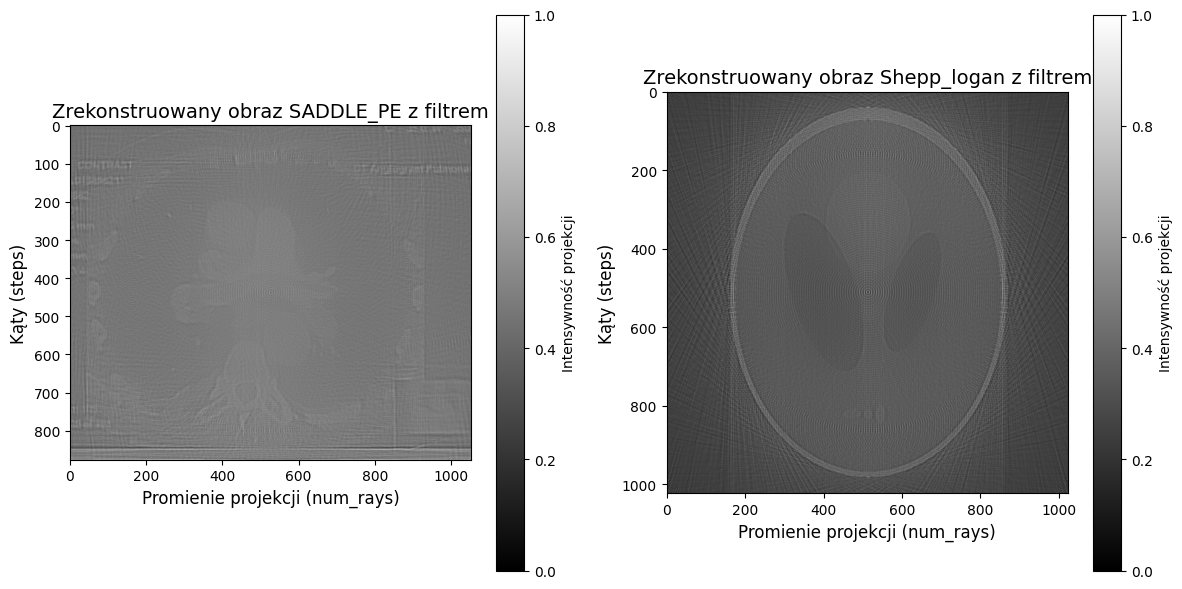

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Wykres dla image1
cax1 = axes[0].imshow(filtered_reconstructed1, cmap="gray", aspect='equal')
axes[0].set_title(f'Zrekonstruowany obraz {file_name1} z filtrem', fontsize=14)
axes[0].set_xlabel('Promienie projekcji (num_rays)', fontsize=12)
axes[0].set_ylabel('Kąty (steps)', fontsize=12)
fig.colorbar(cax1, ax=axes[0], label='Intensywność projekcji')

# Wykres dla image2
cax2 = axes[1].imshow(filtered_reconstructed2, cmap="gray", aspect='equal')
axes[1].set_title(f'Zrekonstruowany obraz {file_name2} z filtrem', fontsize=14)
axes[1].set_xlabel('Promienie projekcji (num_rays)', fontsize=12)
axes[1].set_ylabel('Kąty (steps)', fontsize=12)
fig.colorbar(cax2, ax=axes[1], label='Intensywność projekcji')

# Pokaż oba wykresy
plt.tight_layout()  # Dopasowanie wykresów, aby się nie nakładały
plt.show()

In [10]:
rmse_result = rmse(reconstructed1, filtered_reconstructed1)
print(f'RMSE: {rmse_result}')

RMSE: 0.27316379376424405
